In [1]:
import os
import sys
import argparse
import csv
import pandas as pd
import datetime as dt
import numpy as np
from pprint import pprint
from tqdm import tqdm
from pytictoc import TicToc
import traceback
from statistics import median
from statistics import mode
from statistics import mean
from statistics import stdev
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import stats
from scipy import signal
import portion as P
import math
from sklearn.neighbors import KernelDensity

# ******************************* User Settings *******************************
database = "/home/wmnlab/D/database/"
date = "2022-12-19"
devices = sorted([
    # "sm00",
    # "sm01",
    # "sm02",
    # "sm03",
    # "sm04",
    # "sm05",
    # "sm06",
    # "sm07",
    # "sm08",
    "qc00",
    # "qc01",
    # "qc02",
    # "qc03",
])
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
            # If the list is None, it will not list as directories.
            # If the list is empty, it will list all directories in the current directory by default.
            # If the number of experiment times != the length of existing directories of list, it would trigger warning and skip the directory.
    # "tsync": (1, None),
    "_tsync": (2, []),
    # "_Bandlock_Udp": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp": (4, ["#03", "#04", "#05", "#06"]),
    # "_Bandlock_Udp": (4, []),
    # "_Bandlock_Udp": (6, []),
    # "_Bandlock_Udp_B1_B3":  (4, []),
    # "_Bandlock_Udp_B3_B28": (4, []),
    # "_Bandlock_Udp_B28_B1": (4, []),
}

class Payload:
    LENGTH = 250              # (Bytes)
    TAG = "000425d401df5e76"  # 2 71828 3 1415926 (hex)            : 8-bytes
    OFS_TIME = (16, 24)       # epoch time of 'yyyy/mm/dd hh:mm:ss': 4-bytes
    OFS_USEC = (24, 32)       # microsecond (usec)                 : 4-bytes
    OFS_SEQN = (32, 40)       # sequence number (start from 1)     : 4-bytes
class ServerIP:
    PUBLIC = "140.112.20.183"  # 2F    
    PRIVATE = "192.168.1.251"  # 2F
    # PRIVATE = "192.168.1.248"  # 2F previous
    # PUBLIC = "140.112.17.209"  # 3F
    # PRIVATE = "192.168.1.108"  # 3F

DATA_RATE = 200e3  # bits-per-second
PKT_RATE = DATA_RATE / Payload.LENGTH / 8  # packets-per-second
print("packet_rate (pps):", PKT_RATE, "\n")
# *****************************************************************************

packet_rate (pps): 100.0 



In [2]:
def t_mean(timedeltas):
    """
    Average of a list of timedelta.
    """
    return sum(timedeltas, dt.timedelta(0)) / len(timedeltas) if len(timedeltas) else 0

def t_stdev(timedeltas):
    n = len(timedeltas)
    mean = t_mean(timedeltas)
    dev = [x - mean for x in timedeltas]
    dev2 = [x*x for x in dev]
    return math.sqrt(sum(dev2) / n)

def truncate(txdf, rxdf):
    """
    Truncate the rows of lost packets.
    """
    tx_arr = list(zip(txdf['sequence.number'].array, txdf['Timestamp'].array, txdf['Timestamp_epoch'].array))
    rx_arr = list(zip(rxdf['sequence.number'].array, rxdf['Timestamp'].array, rxdf['Timestamp_epoch'].array))
    _tx_arr = []
    i, j = 0, 0
    N = len(rx_arr)
    # print(tx_arr[i][0])

    for i in range(len(tx_arr)):
        while tx_arr[i][0] > rx_arr[j][0]:
            j += 1
        # if tx_arr[i][0] < rx_arr[j][0]:
        #     pass  # i += 1 by for-loop
        if tx_arr[i][0] == rx_arr[j][0]:
            _tx_arr.append(tx_arr[i])
            if j < N-1:
                j += 1
    ### Since the transmission is stopped by client,
    ### the ending sequence of Downlink-Tx/Uplink-Rx (Server-Side) is larger than Downlink-Rx/Uplink-Tx (Client-Side).
    M = min(len(_tx_arr), len(rx_arr))
    return _tx_arr[:M], rx_arr[:M]

def calc_delta(txdl_df, rxdl_df, txul_df, rxul_df):
    """
    Calculate the time delta between server and client.
        If the client is behind server, delta > 0
        If the client is ahead of server, delta < 0
        server clock := client clock + delta
        
    Returns:
        delta (datetime.timedelta)
        delta (float)
    """
    ### Since the transmission is launched by client, the starting time of Uplink is ahead of Downlink.
    # seq_diff = round(500e-3 * PKT_RATE)
    # txul_df = txul_df[txul_df['sequence.number'] > seq_diff].reset_index(drop=True)
    # rxul_df = rxul_df[rxul_df['sequence.number'] > seq_diff].reset_index(drop=True)
    
    txdl_arr, rxdl_arr = truncate(txdl_df, rxdl_df)
    txul_arr, rxul_arr = truncate(txul_df, rxul_df)

    M = min(len(txdl_arr), len(txul_arr))
    txdl_arr, rxdl_arr, txul_arr, rxul_arr = txdl_arr[:M], rxdl_arr[:M], txul_arr[:M], rxul_arr[:M]
    
    timedelta_list = []
    epoch_delta_list = []
    for ts1, ts2, ts3, ts4 in zip(txdl_arr, rxdl_arr, txul_arr, rxul_arr):
        latency_dl = ts2[1] - ts1[1]
        epoch_latency_dl = ts2[2] - ts1[2]
        latency_ul = ts4[1] - ts3[1]
        epoch_latency_ul = ts4[2] - ts3[2]
        timedelta_list.append((latency_ul - latency_dl) / 2)
        epoch_delta_list.append((epoch_latency_ul - epoch_latency_dl) / 2)
    
    # print(type(timedelta_list[0]))              # <class 'pandas._libs.tslibs.timedeltas.Timedelta'> : datetime64[ns]
    # print(type(dt.timedelta(microseconds=10)))  # <class 'datetime.timedelta'> : microseconds

    # print(t_mean(timedelta_list))
    # print(median(timedelta_list))

    timedeltas = [t_mean(timedelta_list), median(timedelta_list)]
    epoch_deltas = [mean(epoch_delta_list), median(epoch_delta_list)]
    timedelta = (max(timedeltas).round('us'), min(timedeltas).round('us'))
    epoch_delta = (round(max(epoch_deltas), 6), round(min(epoch_deltas), 6))
    ### Use mean or median: https://www.scribbr.com/statistics/central-tendency/
    ### Pandas.Timedelta: https://pandas.pydata.org/docs/reference/api/pandas.Timedelta.html
    ### Pandas.Timedelta.round: https://pandas.pydata.org/docs/reference/api/pandas.Timedelta.round.html
    # return timedelta, epoch_delta
    return timedelta_list, epoch_delta_list

def del_outliers(num_list):
    _num_list = sorted(num_list)
    # print(_num_list)
    print("Length of list:", len(_num_list))

    upper_q = np.percentile(_num_list, 75)
    lower_q = np.percentile(_num_list, 25)
    iqr = (upper_q - lower_q) * 1.5
    q_set = (lower_q - iqr, upper_q + iqr)
    # print(q_set)

    result_list = []
    ret_list = []
    # for i, x in enumerate(_num_list):
    #     if x >= q_set[0] and x <= q_set[1]:
    #         result_list.append(x)
    #         ret_list.append(i)
    for i, x in enumerate(num_list):
        if x >= q_set[0] and x <= q_set[1]:
            result_list.append(x)
            ret_list.append(i)
    # print(result_list)
    print("Length of resulting list:", len(result_list))
    return result_list, ret_list

def del_outliers_2(num_list):
    _num_list = sorted(num_list)

    upper_q = np.percentile(_num_list, 75)
    lower_q = np.percentile(_num_list, 25)
    # iqr = (upper_q - lower_q) * 1.5
    # q_set = (lower_q - iqr, upper_q + iqr)
    q_set = (lower_q, upper_q)

    result_list = []
    ret_list = []
    for i, x in enumerate(_num_list):
        if x >= q_set[0] and x <= q_set[1]:
            result_list.append(x)
            ret_list.append(i)
    return result_list, ret_list

def makedir(dirpath, mode=0):  # mode=1: show message, mode=0: hide message
    if os.path.isdir(dirpath):
        if mode:
            print("mkdir: cannot create directory '{}': directory has already existed.".format(dirpath))
        return
    ### recursively make directory
    _temp = []
    while not os.path.isdir(dirpath):
        _temp.append(dirpath)
        dirpath = os.path.dirname(dirpath)
    while _temp:
        dirpath = _temp.pop()
        print("mkdir", dirpath)
        os.mkdir(dirpath)

/home/wmnlab/D/database/2022-12-19/_tsync
|___ /home/wmnlab/D/database/2022-12-19/_tsync/qc00
|     2
|    |___ /home/wmnlab/D/database/2022-12-19/_tsync/qc00/#01
|    |___ /home/wmnlab/D/database/2022-12-19/_tsync/qc00/#02

------------------------------------------
2022-12-19 _tsync qc00 #01
------------------------------------------
[-0.01627876222712813,-0.0023049279210915147]
[6, 10, 15, 20, 27, 31, 35, 41, 49, 53, 58, 71, 80, 85, 94, 100, 107, 110, 116, 120, 139, 156, 170, 174, 182, 188, 192, 200, 210, 214, 218, 223, 226, 231, 237, 244, 253, 261, 265, 270, 279, 282, 286, 294, 299, 302, 307, 310, 318, 328, 332, 336, 343, 347, 354, 357, 363, 366, 369, 375, 380, 384, 387, 391, 398, 405, 408, 413, 416, 422, 431, 439, 445, 451, 454, 460, 466, 470, 474, 483, 487, 491, 495, 498, 504, 512, 517, 522, 524, 527, 530, 534, 536, 539, 543, 547, 551, 555, 557, 564, 571, 578, 586, 593, 601, 607, 614, 617, 621, 630, 634, 636, 644, 652, 659, 662, 666, 673, 676, 684, 687, 690, 695, 698, 703, 710, 7

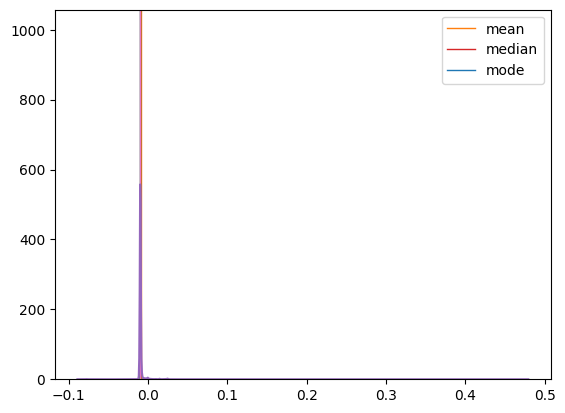

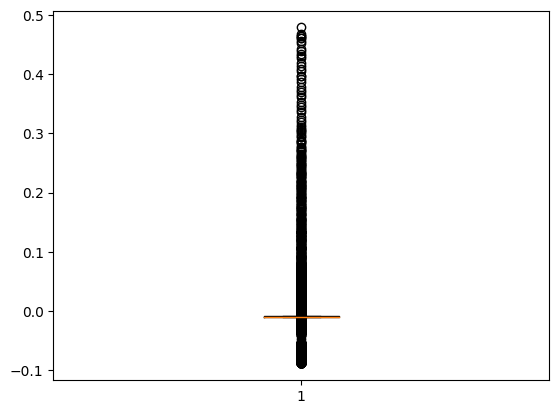

In [3]:
def main():
    txdl_df = pd.read_csv(os.path.join(source_dir, "udp_dnlk_server_pkt_brief.csv"))
    rxdl_df = pd.read_csv(os.path.join(source_dir, "udp_dnlk_client_pkt_brief.csv"))
    txul_df = pd.read_csv(os.path.join(source_dir, "udp_uplk_client_pkt_brief.csv"))
    rxul_df = pd.read_csv(os.path.join(source_dir, "udp_uplk_server_pkt_brief.csv"))
    txdl_df['Timestamp'] = pd.to_datetime(txdl_df['Timestamp'])  # transmitted time from server
    rxdl_df['Timestamp'] = pd.to_datetime(rxdl_df['Timestamp'])  # arrival time to client
    txul_df['Timestamp'] = pd.to_datetime(txul_df['Timestamp'])  # transmitted time from client
    rxul_df['Timestamp'] = pd.to_datetime(rxul_df['Timestamp'])  # arrival time to server
    txdl_df['payload.time'] = pd.to_datetime(txdl_df['payload.time'])
    rxdl_df['payload.time'] = pd.to_datetime(rxdl_df['payload.time'])
    txul_df['payload.time'] = pd.to_datetime(txul_df['payload.time'])
    rxul_df['payload.time'] = pd.to_datetime(rxul_df['payload.time'])
    
    # timedelta, epoch_delta = calc_delta(txdl_df, rxdl_df, txul_df, rxul_df)
    # print(timedelta, epoch_delta)
    # with open(os.path.join(target_dir, "delta.txt"), 'w') as f:
    #     f.write(str(epoch_delta))
    
    timedeltas, epoch_deltas = calc_delta(txdl_df, rxdl_df, txul_df, rxul_df)

    # n, bins, patches = plt.hist(epoch_deltas, 1000, density=False, facecolor='g', alpha=0.75)
    # plt.grid(True)
    # plt.show()

    # plt.boxplot(epoch_deltas)
    # plt.show()

    # print(epoch_deltas[0:5])
    # print(timedeltas[0:5])
    # epoch_deltas, ret_list = del_outliers(epoch_deltas)
    # timedeltas = [timedeltas[i] for i in ret_list]
    # timedeltas = list(map(lambda i: timedeltas[i], ret_list))
    
    kde = stats.gaussian_kde(epoch_deltas)
    xx = np.linspace(min(epoch_deltas), max(epoch_deltas), 1000)
    yy = kde(xx)

    stdev_1 = P.closed(mean(epoch_deltas) - stdev(epoch_deltas), mean(epoch_deltas) + stdev(epoch_deltas))
    # stdev_2 = P.closed(t_mean(timedeltas) - t_stdev(timedeltas), t_mean(timedeltas) + t_stdev(timedeltas))
    print(stdev_1)
    # print(stdev_2)
    max_index = list(signal.argrelextrema(yy, np.greater)[0])
    print(max_index)
    print([xx[i] for i in max_index])
    print(stdev(epoch_deltas))
    benchmarks = [xx[i] for i in max_index if xx[i] in stdev_1]
    n, bins, patches = plt.hist(epoch_deltas, 2000, density=True, facecolor='g', alpha=0.6)
    plt.axvline(mean(epoch_deltas), c='tab:orange', label='mean', linewidth=1)
    plt.axvline(median(epoch_deltas), c='tab:red', label='median', linewidth=1)
    plt.axvline(mode(epoch_deltas), c='tab:blue', label='mode', linewidth=1)
    # [plt.axvline(xx[i], c='tab:pink', linewidth=0.75) for i in max_index]
    [plt.axvline(item, c='tab:pink', linewidth=0.75) for item in benchmarks]
    # plt.axvline(mean(epoch_deltas) + stdev(epoch_deltas), c='tab:pink', linewidth=0.75)
    # plt.axvline(mean(epoch_deltas) - stdev(epoch_deltas), c='tab:pink', linewidth=0.75)
    plt.plot(xx, yy, c='tab:purple', linewidth=1.5)
    # plt.grid(True)
    plt.legend()
    plt.show()

    plt.boxplot(epoch_deltas)
    plt.show()

    x = list(range(len(epoch_deltas)))
    h = epoch_deltas
    plt.bar(x,h)
    plt.show()
    
    print()


for expr, (times, traces) in exps.items():
    print(os.path.join(database, date, expr))
    for dev in devices:
        if not os.path.isdir(os.path.join(database, date, expr, dev)):
            print("|___ {} does not exist.".format(os.path.join(database, date, expr, dev)))
            continue
        
        print("|___", os.path.join(database, date, expr, dev))
        if traces == None:
            # print(os.path.join(database, date, expr, dev))
            continue
        elif len(traces) == 0:
            traces = sorted(os.listdir(os.path.join(database, date, expr, dev)))
        
        print("|    ", times)
        traces = [trace for trace in traces if os.path.isdir(os.path.join(database, date, expr, dev, trace))]
        if len(traces) != times:
            print("***************************************************************************************")
            print("Warning: the number of traces does not match the specified number of experiment times.")
            print("***************************************************************************************")
        for trace in traces:
            print("|    |___", os.path.join(database, date, expr, dev, trace))
    print()

t = TicToc()  # create instance of class
t.tic()       # Start timer
err_handles = []
for expr, (times, traces) in exps.items():
    for dev in devices:
        if not os.path.isdir(os.path.join(database, date, expr, dev)):
            print("{} does not exist.\n".format(os.path.join(database, date, expr, dev)))
            continue

        if traces == None:
            print("------------------------------------------")
            print(date, expr, dev)
            print("------------------------------------------")
            source_dir = os.path.join(database, date, expr, dev)
            target_dir = os.path.join(database, date, expr, dev)
            makedir(target_dir)
            filenames = os.listdir(source_dir)
            main()
            continue
        elif len(traces) == 0:
            traces = sorted(os.listdir(os.path.join(database, date, expr, dev)))
        
        traces = [trace for trace in traces if os.path.isdir(os.path.join(database, date, expr, dev, trace))]
        for trace in traces:
            print("------------------------------------------")
            print(date, expr, dev, trace)
            print("------------------------------------------")
            source_dir = os.path.join(database, date, expr, dev, trace, "middle")
            target_dir = os.path.join(database, date, expr, dev, trace, "middle")
            makedir(target_dir)
            filenames = os.listdir(source_dir)
            main()
t.toc()  # Time elapsed since t.tic()

/home/wmnlab/D/database/2022-12-19/_tsync
|___ /home/wmnlab/D/database/2022-12-19/_tsync/qc00
|     2
|    |___ /home/wmnlab/D/database/2022-12-19/_tsync/qc00/#01
|    |___ /home/wmnlab/D/database/2022-12-19/_tsync/qc00/#02

------------------------------------------
2022-12-19 _tsync qc00 #01
------------------------------------------
Length of list: 719994
Length of resulting list: 645268
[-0.010047563783459007,-0.00926997815461419]
[18, 426, 510]
[-0.010676838256217338, -0.009787343643807076, -0.009604212400075552]
0.00038879281442240923


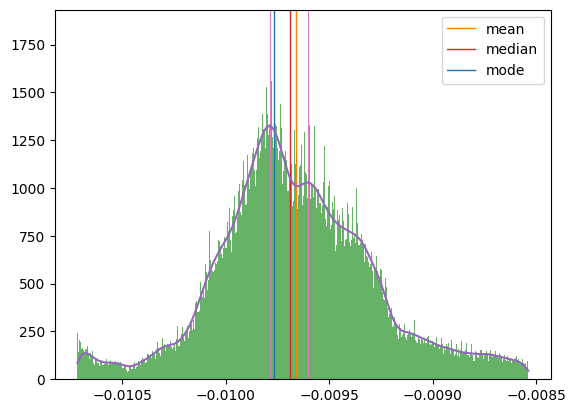

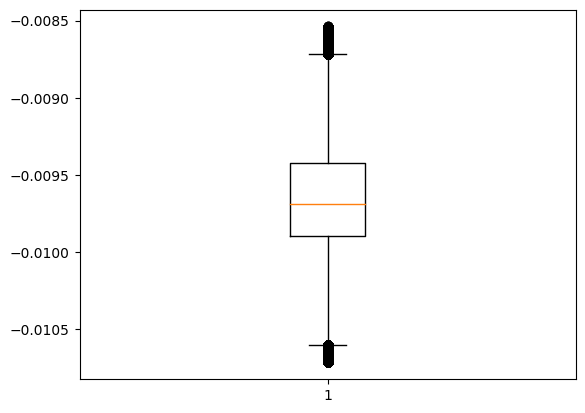

In [3]:
def main():
    txdl_df = pd.read_csv(os.path.join(source_dir, "udp_dnlk_server_pkt_brief.csv"))
    rxdl_df = pd.read_csv(os.path.join(source_dir, "udp_dnlk_client_pkt_brief.csv"))
    txul_df = pd.read_csv(os.path.join(source_dir, "udp_uplk_client_pkt_brief.csv"))
    rxul_df = pd.read_csv(os.path.join(source_dir, "udp_uplk_server_pkt_brief.csv"))
    txdl_df['Timestamp'] = pd.to_datetime(txdl_df['Timestamp'])  # transmitted time from server
    rxdl_df['Timestamp'] = pd.to_datetime(rxdl_df['Timestamp'])  # arrival time to client
    txul_df['Timestamp'] = pd.to_datetime(txul_df['Timestamp'])  # transmitted time from client
    rxul_df['Timestamp'] = pd.to_datetime(rxul_df['Timestamp'])  # arrival time to server
    txdl_df['payload.time'] = pd.to_datetime(txdl_df['payload.time'])
    rxdl_df['payload.time'] = pd.to_datetime(rxdl_df['payload.time'])
    txul_df['payload.time'] = pd.to_datetime(txul_df['payload.time'])
    rxul_df['payload.time'] = pd.to_datetime(rxul_df['payload.time'])
    
    # timedelta, epoch_delta = calc_delta(txdl_df, rxdl_df, txul_df, rxul_df)
    # print(timedelta, epoch_delta)
    # with open(os.path.join(target_dir, "delta.txt"), 'w') as f:
    #     f.write(str(epoch_delta))
    
    timedeltas, epoch_deltas = calc_delta(txdl_df, rxdl_df, txul_df, rxul_df)

    # n, bins, patches = plt.hist(epoch_deltas, 1000, density=False, facecolor='g', alpha=0.75)
    # plt.grid(True)
    # plt.show()

    # plt.boxplot(epoch_deltas)
    # plt.show()

    # print(epoch_deltas[0:5])
    # print(timedeltas[0:5])
    epoch_deltas, ret_list = del_outliers(epoch_deltas)
    timedeltas = [timedeltas[i] for i in ret_list]
    # timedeltas = list(map(lambda i: timedeltas[i], ret_list))
    
    kde = stats.gaussian_kde(epoch_deltas)
    xx = np.linspace(min(epoch_deltas), max(epoch_deltas), 1000)
    yy = kde(xx)

    stdev_1 = P.closed(mean(epoch_deltas) - stdev(epoch_deltas), mean(epoch_deltas) + stdev(epoch_deltas))
    # stdev_2 = P.closed(t_mean(timedeltas) - t_stdev(timedeltas), t_mean(timedeltas) + t_stdev(timedeltas))
    print(stdev_1)
    # print(stdev_2)
    max_index = list(signal.argrelextrema(yy, np.greater)[0])
    print(max_index)
    print([xx[i] for i in max_index])
    print(stdev(epoch_deltas))
    benchmarks = [xx[i] for i in max_index if xx[i] in stdev_1]
    n, bins, patches = plt.hist(epoch_deltas, 2000, density=True, facecolor='g', alpha=0.6)
    plt.axvline(mean(epoch_deltas), c='tab:orange', label='mean', linewidth=1)
    plt.axvline(median(epoch_deltas), c='tab:red', label='median', linewidth=1)
    plt.axvline(mode(epoch_deltas), c='tab:blue', label='mode', linewidth=1)
    # [plt.axvline(xx[i], c='tab:pink', linewidth=0.75) for i in max_index]
    [plt.axvline(item, c='tab:pink', linewidth=0.75) for item in benchmarks]
    # plt.axvline(mean(epoch_deltas) + stdev(epoch_deltas), c='tab:pink', linewidth=0.75)
    # plt.axvline(mean(epoch_deltas) - stdev(epoch_deltas), c='tab:pink', linewidth=0.75)
    plt.plot(xx, yy, c='tab:purple', linewidth=1.5)
    # plt.grid(True)
    plt.legend()
    plt.show()

    plt.boxplot(epoch_deltas)
    plt.show()

    x = list(range(len(epoch_deltas)))
    h = epoch_deltas
    plt.bar(x,h)
    plt.show()
    
    print()


for expr, (times, traces) in exps.items():
    print(os.path.join(database, date, expr))
    for dev in devices:
        if not os.path.isdir(os.path.join(database, date, expr, dev)):
            print("|___ {} does not exist.".format(os.path.join(database, date, expr, dev)))
            continue
        
        print("|___", os.path.join(database, date, expr, dev))
        if traces == None:
            # print(os.path.join(database, date, expr, dev))
            continue
        elif len(traces) == 0:
            traces = sorted(os.listdir(os.path.join(database, date, expr, dev)))
        
        print("|    ", times)
        traces = [trace for trace in traces if os.path.isdir(os.path.join(database, date, expr, dev, trace))]
        if len(traces) != times:
            print("***************************************************************************************")
            print("Warning: the number of traces does not match the specified number of experiment times.")
            print("***************************************************************************************")
        for trace in traces:
            print("|    |___", os.path.join(database, date, expr, dev, trace))
    print()

t = TicToc()  # create instance of class
t.tic()       # Start timer
err_handles = []
for expr, (times, traces) in exps.items():
    for dev in devices:
        if not os.path.isdir(os.path.join(database, date, expr, dev)):
            print("{} does not exist.\n".format(os.path.join(database, date, expr, dev)))
            continue

        if traces == None:
            print("------------------------------------------")
            print(date, expr, dev)
            print("------------------------------------------")
            source_dir = os.path.join(database, date, expr, dev)
            target_dir = os.path.join(database, date, expr, dev)
            makedir(target_dir)
            filenames = os.listdir(source_dir)
            main()
            continue
        elif len(traces) == 0:
            traces = sorted(os.listdir(os.path.join(database, date, expr, dev)))
        
        traces = [trace for trace in traces if os.path.isdir(os.path.join(database, date, expr, dev, trace))]
        for trace in traces:
            print("------------------------------------------")
            print(date, expr, dev, trace)
            print("------------------------------------------")
            source_dir = os.path.join(database, date, expr, dev, trace, "middle")
            target_dir = os.path.join(database, date, expr, dev, trace, "middle")
            makedir(target_dir)
            filenames = os.listdir(source_dir)
            main()
t.toc()  # Time elapsed since t.tic()